# Исследование рынка заведений общественного питания Москвы

Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами, мы решили обратиться к инвесторам, однако, их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?


Партнёры пропросили нас подготовить исследование рынка.

- **С чем будем работать**:
  -  В распоряжении - открытые данные о заведениях общественного питания в Москве.
- **Основные этапы**:
  - Подготовка данных (обработка пропусков, приведение данных к нужному типу, "чистка" данных, необходимая для дальнейшего исследования).
  - Проведение исследовательского анализа (исследование видов объектов общественного питания, поиск закономерностей в сетевых и несетевых заведениях, зависимость количества посадочных мест от заведения, распределение объектов общественного питания по улицам и районам Москвы).
  - Подготовка презентации исследования для инвесторов.

## Изучение и предобработка данных

Импортируем необходимые для работы библиотеки.

In [300]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Рассмотрим данные в таблице и выведем общую информацию.

In [301]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


В первом приближении, сразу, видим дубль в названии заведения и его адресе. Согласно Яндекс.Картам, по адресу "улица Земляной Вал, дом 33", находится ТРК Атриум. Поэтому, вполне допустимо, что там могут располагаться два заведения одной сети общественного питания. При обработке дубликатов учтём это.

Посмотрим на формат данных.

In [302]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В целом, формат данных устраивает, но со столбцом "сетевых-несетевых" заведений можно кое-что сделать. 

Посчитаем общие дубликаты по таблице.

In [303]:
rest_data.duplicated().sum()

0

Посмотрим на пропуски.

In [304]:
rest_data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Переименуем столбец с количеством посадочных мест.

In [305]:
rest_data.rename(columns = ({'number':'seats_count'}), inplace=True)

Вернёмся к нашим дубликатам названия и адреса. Посмотрим, какую долю в таблице они составляют.

In [306]:
rest_data.duplicated(subset=['object_name', 'address']).mean()

0.01347130027333073

Около одного процента. Не будем полностью от них избавляться, а удалим только каждый первый встречающийся дубль.

In [307]:
rest_data.drop_duplicates(subset=['object_name', 'address'], keep='last', inplace=True)
rest_data.reset_index(drop=True, inplace=True)

Для удобства, в столбце с типом распространения, поменяем "да" и "нет" на "сетевое" и "несетевое", соответственно.

In [308]:
rest_data['chain'] = rest_data['chain'].apply(lambda x: 'сетевое' if x=='да' else 'несетевое')

In [309]:
rest_data['chain'].value_counts()

несетевое    12218
сетевое       2941
Name: chain, dtype: int64

Как видим, фактически, несетевых заведений  гораздо больше.

Рассмотрим типы объектов общественного питания.

In [310]:
rest_data['object_type'].value_counts().to_frame()

,object_type
кафе,6007
столовая,2574
ресторан,2266
предприятие быстрого обслуживания,1884
бар,852
буфет,568
кафетерий,391
закусочная,346
магазин (отдел кулинарии),271


Всё по ГОСТу.

Узнаем, что по посадочным местам.

In [311]:
rest_data[['object_type', 'seats_count']].sort_values('seats_count', ascending=False)

,object_type,seats_count
12567,бар,1700
8050,ресторан,1500
8247,столовая,1400
8957,столовая,1288
3658,ресторан,1200
...,...,...
9426,бар,0
11097,магазин (отдел кулинарии),0
9427,предприятие быстрого обслуживания,0
13464,кафе,0


От нуля, до, практически, двух тысяч посадочных мест. 

Посмотрим на просторные заведения, перевалившие за тысячу мест.

In [312]:
rest_data.query('seats_count >= 1000')

,id,object_name,chain,object_type,address,seats_count
2305,26560,Ресторан «АЛЬФА»,несетевое,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",1040
3658,27026,РУМ СЕРВИС,несетевое,ресторан,"город Москва, площадь Европы, дом 2",1200
4447,27024,РУМ СЕРВИС,несетевое,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200
8050,80291,Банкетный зал Шелк,несетевое,ресторан,"город Москва, Большой Саввинский переулок, дом...",1500
8247,27750,СТОЛОВАЯ-БУФЕТ,несетевое,столовая,"город Москва, улица Волхонка, дом 15",1400
8957,19719,КОМБИНАТ ПИТАНИЯ «УПРАВЛЕНИЕ АКАДЕМСЕРВИС»,несетевое,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288
12567,199696,Arena by Soho Family,несетевое,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700


Крупные рестораны и банкетные залы. Подобные заведения имеют место быть, так что оставим их в наших данных.

Возьмём некий "психологический рубеж" в пятьсот и более мест и посчитаем долю таких заведений.

In [313]:
(rest_data['seats_count'] >= 500).mean()

0.002242892011346395

Меньше процента. Не должны сильно повлиять на рассчёты. Оставляем их в таблице.

Сколько же, в среднем, посадочных мест по нашим данным?

In [314]:
rest_data['seats_count'].mean()

59.91239527673329

Около 60 посадочных мест, в среднем, на заведение.

Пробежим по названиям и сформируем топ-10.

In [315]:
rest_data['object_name'].value_counts().to_frame().head(10)

,object_name
Столовая,266
Шаурма,224
Кафе,201
KFC,152
Шоколадница,140
Бургер Кинг,121
Макдоналдс,118
Домино'с Пицца,86
Теремок,83
Крошка Картошка,81


Достаточно расплывчатые "столовые", "шаурмы" и "кафе" оставим как есть - скорее всего, как минимум два из них, будут совпадать с типом заведения, а вот более именитые бренды рассмотрим поближе.

В каких вариантах встречается лидер нашего топа - "KFC"?

In [316]:
rest_data.loc[rest_data['object_name'].str.contains('KFC', case=False), 'object_name'].value_counts()

KFC                                        152
Кафе «KFC»                                  11
Ростикс KFC                                  7
Ресторан «KFC»                               3
Предприятие быстрого обслуживания «KFC»      2
Fridays KFC                                  1
KFC Волгоградский                            1
KFC.                                         1
ПБО «KFC»                                    1
Ресторан быстрого питания KFC                1
ПБО «KFC Покрышкина»                         1
Закусочная «KFC»                             1
Закусочная KFC                               1
КАФЕ KFC                                     1
Ресторан KFC                                 1
РОСТИКС KFC                                  1
Name: object_name, dtype: int64

Неплохо. Приведём его к общему знаменателю и проверим результат.

In [317]:
rest_data.loc[rest_data['object_name'].str.contains('KFC', case=False), 'object_name'] = 'KFC'

In [318]:
rest_data.loc[rest_data['object_name'].str.contains('KFC', case=False), 'object_name'].value_counts()

KFC    186
Name: object_name, dtype: int64

Теперь всё компактно и пригодно к исследованиям. Подобьём прочих "сомнительных" кандидатов.

In [319]:
#пополняется в процессе исследований :)
rest_data.loc[rest_data['object_name'].str.contains('Шоколадница', case=False), 'object_name'] = 'Шоколадница'

rest_data.loc[rest_data['object_name'].str.contains('Бургер Кинг|Burger King', case=False), 'object_name'] = 'Бургер Кинг'

rest_data.loc[rest_data['object_name'].str.contains('Макдоналдс|donalds', case=False), 'object_name'] = 'Макдоналдс'

rest_data.loc[rest_data['object_name'].str.contains("Домино'|domino", case=False), 'object_name'] = 'Доминос Пицца'

rest_data.loc[rest_data['object_name'].str.contains('теремок', case=False), 'object_name'] = 'Теремок'

rest_data.loc[rest_data['object_name'].str.contains(
    'крошка картошка|крошка-картошка', case=False), 'object_name'] = 'Крошка Картошка'

rest_data.loc[rest_data['object_name'].str.contains('прайм стар', case=False), 'object_name'] = 'Прайм стар'

rest_data.loc[rest_data['object_name'].str.contains('му му|му-му', case=False), 'object_name'] = 'Му-Му'

rest_data.loc[rest_data['object_name'].str.contains('старбакс|starbucks', case=False), 'object_name'] = 'Старбакс'

rest_data.loc[rest_data['object_name'].str.contains('кофе хаус', case=False), 'object_name'] = 'Кофе хаус'

Заново выведем топ-10.

In [320]:
rest_data['object_name'].value_counts().to_frame().head(10)

,object_name
Столовая,266
Шаурма,224
Кафе,201
Шоколадница,186
KFC,186
Макдоналдс,170
Бургер Кинг,160
Теремок,115
Доминос Пицца,110
Крошка Картошка,97


Даже "Шоколаднице" не догнать простую, но такую родную, столовую и шаурму.

Предобработка готова, можно приступать к анализу данных.

## Анализ данных

### Соотношение видов объектов общественного питания по количеству.

Построим график общего числа объектов.

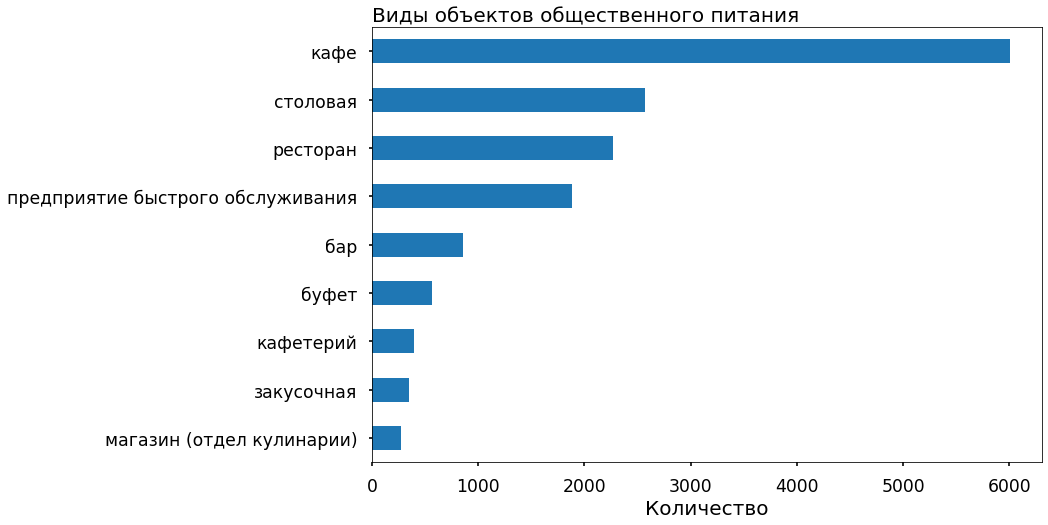

In [321]:
with plt.style.context('seaborn-poster'):
    rest_data['object_type'].value_counts(ascending=True).plot\
    (kind='barh', fontsize='xx-large', figsize=(12, 8), rot=0, legend=None)
    plt.title('Виды объектов общественного питания', loc='left', fontsize=20)
    plt.xlabel('Количество', fontsize=20)
    plt.show()

В лидерах кафе. Столовые, рестораны и предприятия быстрого обслуживания отстают достаточно сильно.

Узнаем соотношение видов объектов к общему числу.

In [322]:
object_types = rest_data['object_type'].value_counts(normalize=True).apply('{:.1%}'.format).to_frame().reset_index()
object_types.columns = ['object_type', 'ratio']
object_types

,object_type,ratio
0,кафе,39.6%
1,столовая,17.0%
2,ресторан,14.9%
3,предприятие быстрого обслуживания,12.4%
4,бар,5.6%
5,буфет,3.7%
6,кафетерий,2.6%
7,закусочная,2.3%
8,магазин (отдел кулинарии),1.8%


Построим график.

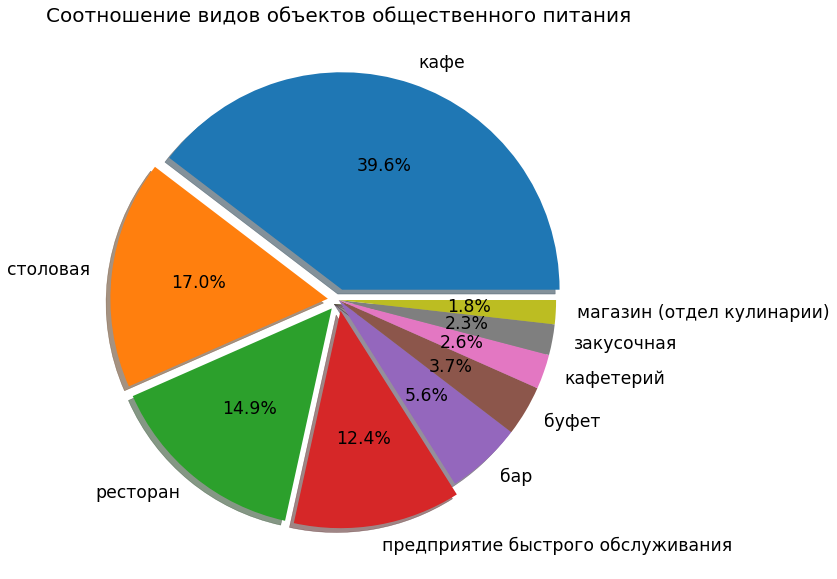

In [323]:
with plt.style.context('seaborn-poster'):
    explode = [0.05, 0.05, 0.05, 0.05, 0, 0, 0, 0, 0]
    rest_data['object_type'].value_counts(normalize=True).plot(
        kind='pie', fontsize='xx-large', figsize=(10, 10), explode=explode, shadow=True, autopct='%1.1f%%')
    plt.title('Соотношение видов объектов общественного питания', loc='center', fontsize=20)
    plt.ylabel('')
    plt.show()

Наибольшую долю - почти 40 процентов - составляют заведения типа "кафе".

### Соотношение сетевых и несетевых заведений по количеству.

Вспомним распределение по числу заведений.

In [324]:
rest_data['chain'].value_counts().to_frame()

,chain
несетевое,12218
сетевое,2941


Построим график.

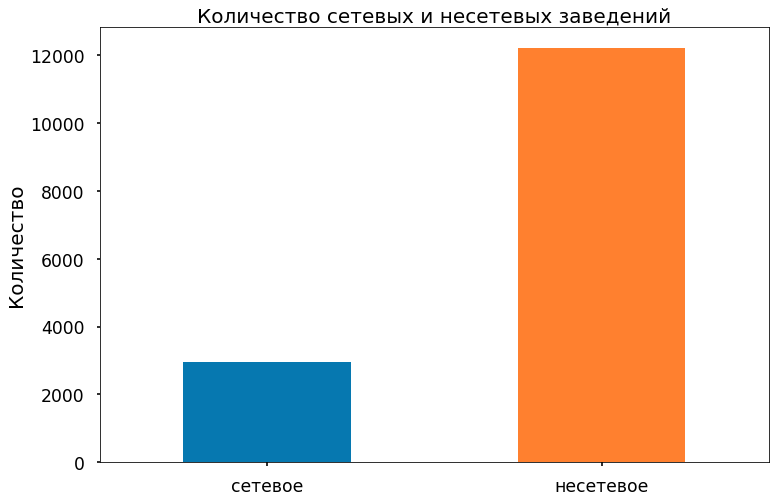

In [325]:
with plt.style.context('seaborn-poster'):
    rest_data['chain'].value_counts(ascending=True).plot\
    (kind='bar', fontsize='xx-large', figsize=(12, 8), rot=0, legend=None, color=['#0678b0', '#ff802f'])
    plt.title('Количество сетевых и несетевых заведений', loc='center', fontsize=20)
    plt.ylabel('Количество', fontsize=20)
    plt.show()

График соотношения.

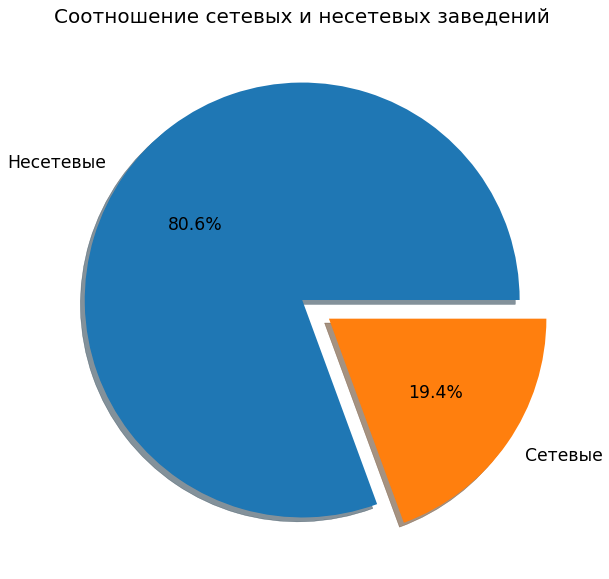

In [326]:
with plt.style.context('seaborn-poster'):
    rest_data['chain'].value_counts().plot(
        kind='pie', fontsize='xx-large', figsize=(10, 10), labels=[
            'Несетевые', 'Сетевые'], explode=(0, 0.15), shadow=True, autopct='%1.1f%%')
    plt.title('Соотношение сетевых и несетевых заведений', loc='center', fontsize=20)
    plt.ylabel('')
    plt.show()

Подавляющее число заведений - 80 процентов - имеют несетевую форму распространиения.

### Для какого вида объекта общественного питания характерно сетевое распространение?

Сгруппируем данные по видам объектов и распространению.

In [327]:
rest_chain_data = rest_data.groupby(['object_type', 'chain']).id.count().to_frame().\
sort_values('id', ascending=False).reset_index()

Построим график.

In [329]:
chain = rest_chain_data.loc[rest_chain_data['chain'] == 'сетевое', ['object_type', 'id']]
not_chain = rest_chain_data.loc[rest_chain_data['chain'] == 'несетевое', ['object_type', 'id']]
chain_data = chain.merge(not_chain, on='object_type', suffixes=('_chain', '_not_chain'))

In [336]:
chain_data['chain_prop'] = ((chain_data['id_chain'] / chain_data['id_not_chain'])*100).round()
chain_data = chain_data.sort_values('chain_prop', ascending=False)

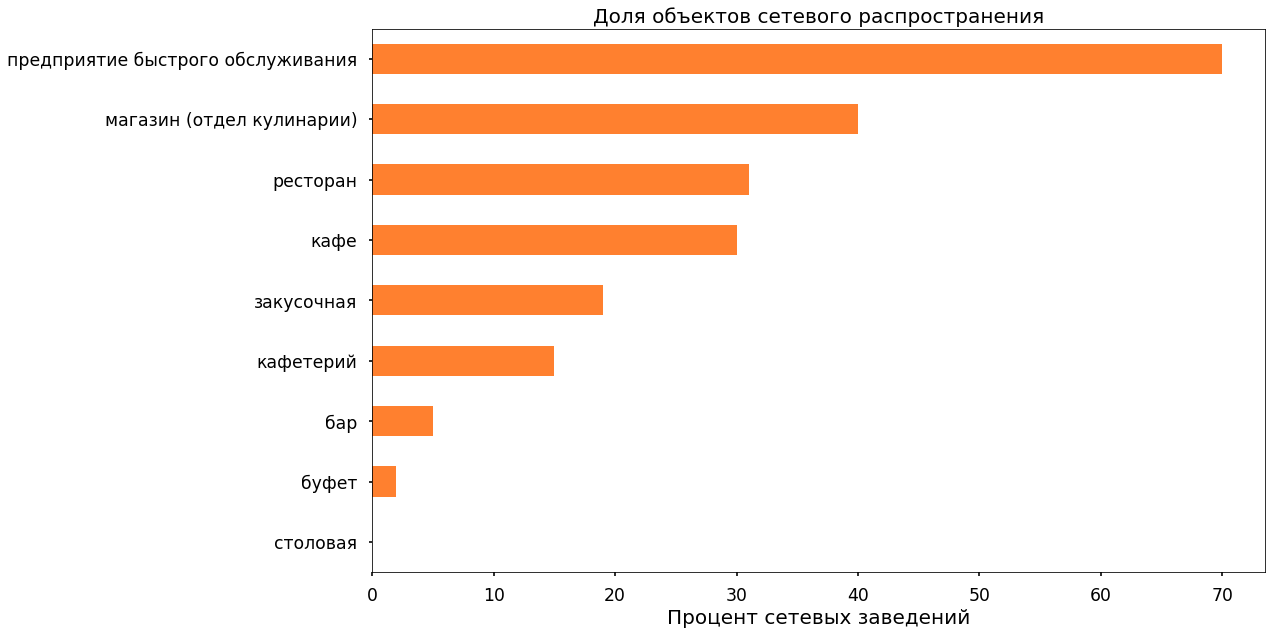

In [349]:
with plt.style.context('seaborn-poster'):
    chain_data.sort_values('chain_prop').\
    plot(kind='barh', x='object_type', y='chain_prop', fontsize='xx-large', figsize=(16, 10), rot=0, legend=None, color='#ff802f')
    plt.title('Доля объектов сетевого распространения', loc='center', fontsize=20)
    plt.ylabel('')
    plt.xlabel('Процент сетевых заведений', fontsize=20)
    plt.show()

В большей степени, сетевое распространение характерно для предприятий быстрого обслуживания, отделов кулинарии и ресторанов.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Сделаем срез по сетевым заведениям.

In [84]:
chain_seat_data = rest_data.query('chain == "сетевое"')

Построим гистограмму распределения.

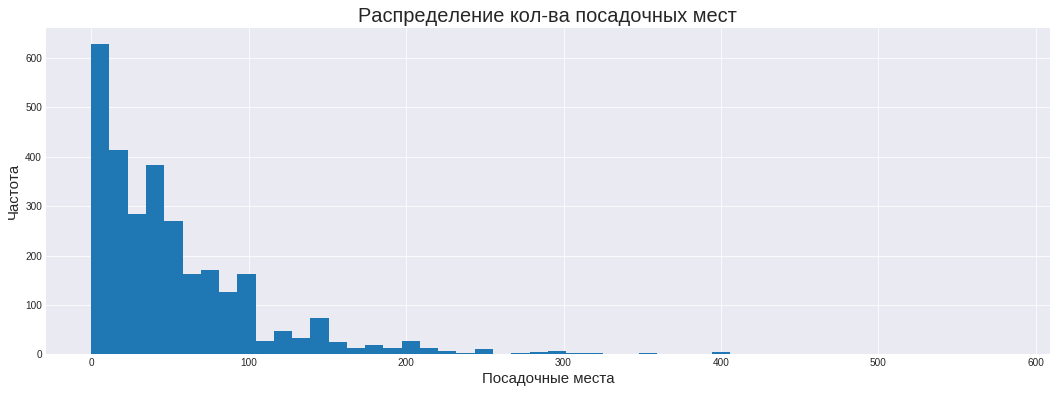

In [85]:
 with plt.style.context('seaborn-dark'):
    chain_seat_data['seats_count'].hist(bins=50, figsize=(18, 6))
    plt.title('Распределение кол-ва посадочных мест', loc='center', fontsize=20)
    plt.xlabel('Посадочные места', fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

Наиболее часто встречаются заведения, с количеством посадочных мест до сотни. Возьмём небольшой запас и сделаем срез на ста пятидесяти местах.

In [86]:
chain_seat_data = chain_seat_data.query('seats_count <= 150')

Посчитаем число заведений внутри сети и среднее количество посадочных мест на заведение.

In [87]:
chain_seats = chain_seat_data.groupby('object_name').agg(
    {'id':'count', 'seats_count':'mean'}).sort_values('id', ascending=False).reset_index()

Выведем топ-10.

In [88]:
chain_seats.head(10)

,object_name,id,seats_count
0,Шоколадница,182,57.928571
1,KFC,179,51.145251
2,Бургер Кинг,158,48.449367
3,Макдоналдс,151,70.039735
4,Теремок,109,25.623853
5,Доминос Пицца,99,18.030303
6,Крошка Картошка,95,21.221053
7,Старбакс,69,42.550725
8,Милти,65,1.430769
9,Суши Wok,61,7.131148


У первой пятёрки разброс, в среднем, от 25 до 70 посадочных мест.

Посмотрим, как распределены заведения внутри сети.

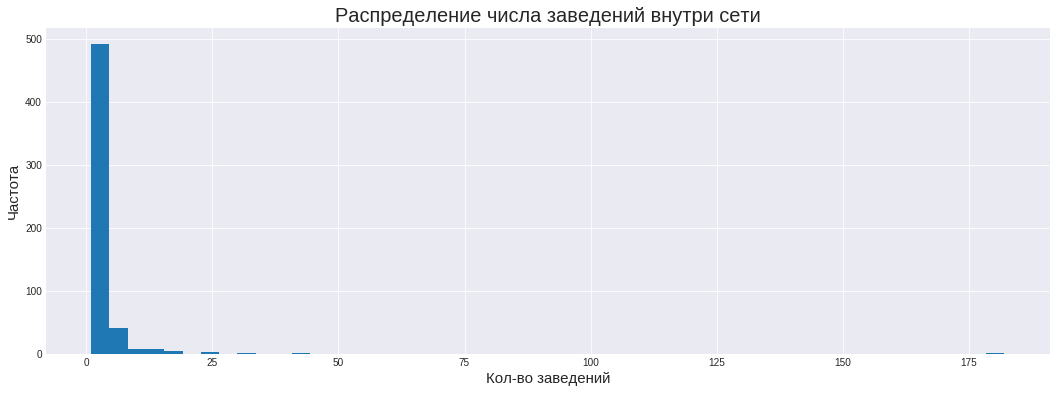

In [89]:
 with plt.style.context('seaborn-dark'):   
    chain_seats['id'].hist(bins=50, figsize=(18, 6))
    plt.title('Распределение числа заведений внутри сети', loc='center', fontsize=20)
    plt.xlabel('Кол-во заведений', fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

Любопытно. Больше всего заведений, которые считаются сетевыми, но, при этом, имеют в своём запасе только один объект общественного питания.

Будем считать, что сетевыми являются те заведения, которые имеют в своём распоряжении три и более объектов.

Найдём среднее количество посадочных мест.

In [90]:
 chain_seats.query('id > 3').seats_count.mean().round(2)

41.53

Около сорока посадочных мест на заведение.

Построим диаграмму рассеяния.

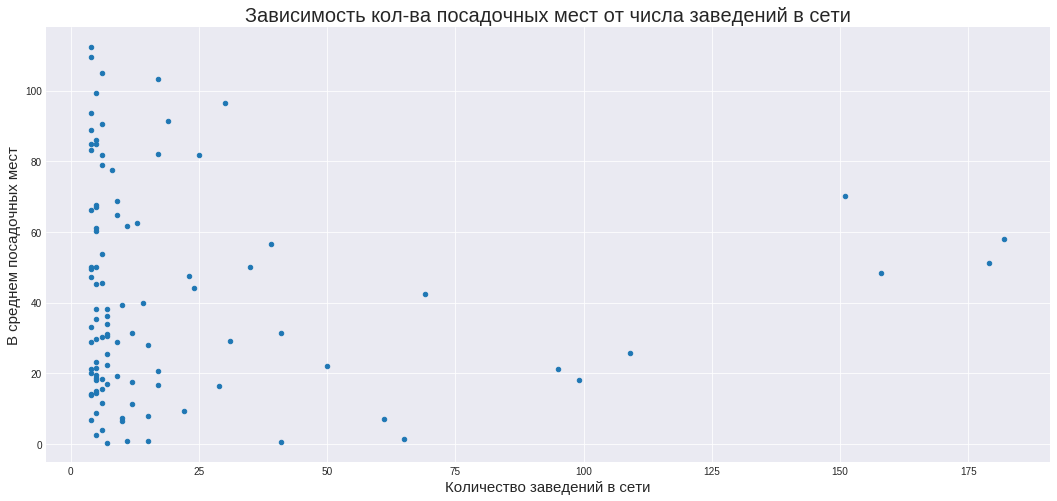

In [91]:
with plt.style.context('seaborn-dark'):
    chain_seats.query('id > 3').\
    plot(x='id', y='seats_count', kind='scatter', grid=True, figsize=(18, 8))
    plt.title('Зависимость кол-ва посадочных мест от числа заведений в сети', loc='center', fontsize=20)
    plt.ylabel('В среднем посадочных мест', fontsize=15)
    plt.xlabel('Количество заведений в сети', fontsize=15)
    plt.show()

Прямой зависимости количества посадочных мест, от количества заведений в сети - нет. Однако, у "малых" сетей (до 10 - 15 заведений), наблюдается тенденция большего числа посадочных мест (до сотни), чем у более распространённых коллег. Сети, с числом заведений от 25 и выше, в среднем, стараются не превышать 60 посадочных мест.

### Среднее количество посадочных мест, для каждого вида объекта общественного питания.

Сгруппируем по типу объекта и посчитаем среднее количество мест.

In [92]:
rest_data.groupby('object_type').agg(
    {'seats_count':'mean'}).round(2).sort_values('seats_count', ascending=False).reset_index()

,object_type,seats_count
0,столовая,130.37
1,ресторан,97.21
2,буфет,51.54
3,бар,43.60
4,кафе,39.83
5,предприятие быстрого обслуживания,20.77
6,кафетерий,9.17
7,закусочная,7.04
8,магазин (отдел кулинарии),5.62


Построим график.

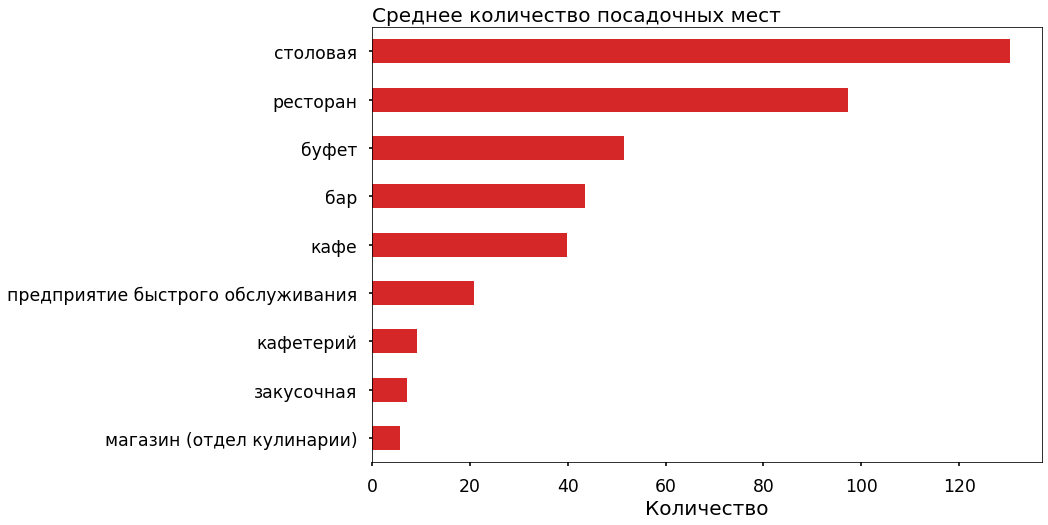

In [93]:
with plt.style.context('seaborn-poster'):
    rest_data.groupby('object_type').agg(
    {'seats_count':'mean'}).round(2).sort_values('seats_count', ascending=True).plot\
    (kind='barh', fontsize='xx-large', figsize=(12, 8), rot=0, legend=None, color='#d62728')
    plt.title('Среднее количество посадочных мест', loc='left', fontsize=20)
    plt.xlabel('Количество', fontsize=20)
    plt.ylabel('')
    plt.show()

В среднем, наибольшее количество посадочных мест, предлагают столовые - 130 мест. Замыкает первую пятёрку, лидер предыдущих подсчётов - кафе, с 40 местами.

### Выделим в отдельный столбец информацию об улице 

При помощи регулярного выражения, выделим улицу, на которой находится заведение, в отдельный столбец.

In [94]:
rest_data['street'] = rest_data['address'].str.\
               extract('(([\-А-яё0-9\s]+)?(улица|переулок|шоссе|проспект|проезд|бульвар|площадь|набережная)([А-яё0-9\s]+)?)')[0]

In [95]:
rest_data.head()

,id,object_name,chain,object_type,address,seats_count,street
0,151635,СМЕТАНА,несетевое,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,несетевое,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,несетевое,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,сетевое,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,несетевое,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


### Построим график ТОП-10 улиц по количеству объектов общественного питания. Узнаем, в каких районах Москвы находятся эти улицы.

Сгруппируем улицы по количеству объектов.

In [96]:
top_streets = rest_data.groupby('street').agg({'id':'count'}).sort_values('id', ascending=False).head(10).reset_index()
top_streets.columns = ['street', 'rest_count']
top_streets

,street,rest_count
0,проспект Мира,197
1,Профсоюзная улица,179
2,Ленинградский проспект,169
3,Пресненская набережная,165
4,Варшавское шоссе,163
5,Ленинский проспект,147
6,проспект Вернадского,127
7,Кутузовский проспект,112
8,Каширское шоссе,110
9,Кировоградская улица,106


Построим график.

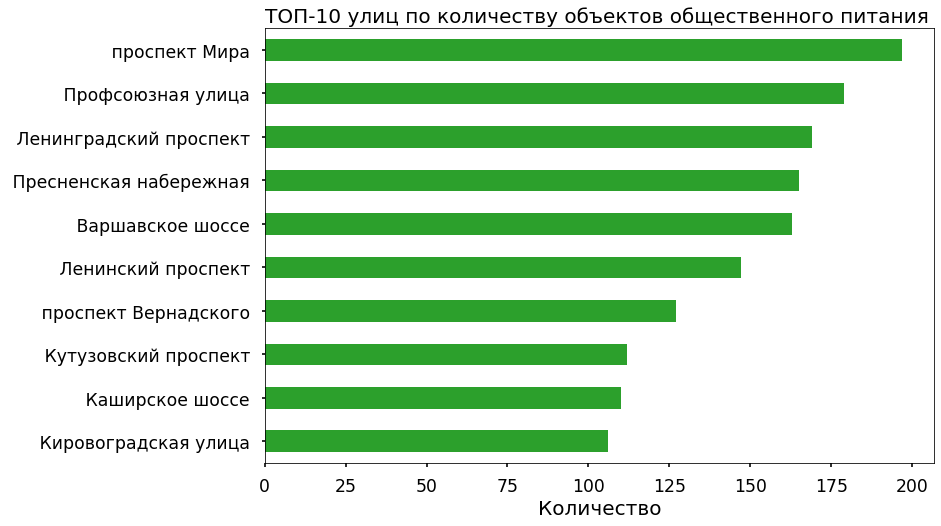

In [97]:
with plt.style.context('seaborn-poster'):
    rest_data.groupby('street').agg({'id':'count'}).sort_values('id').tail(10).plot\
    (kind='barh', color='#2ca02c', fontsize='xx-large', figsize=(12, 8), rot=0, legend=None)
    plt.title('ТОП-10 улиц по количеству объектов общественного питания', loc='left', fontsize=20)
    plt.xlabel('Количество', fontsize=20)
    plt.ylabel('')
    plt.show()

Вся первая десятка переваливает сотню заведений на одну улицу.

Воспользуемся данными по районам и округам из внешнего источника.

In [98]:
districts = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/qYbArczIyZIjDw')

In [99]:
districts

,admarea,district,street
0,Северо-Восточный административный округ,Ярославский район,улица Егора Абакумова
1,Центральный административный округ,Таганский район,улица Талалихина
2,Центральный административный округ,Таганский район,Абельмановская улица
3,Северо-Восточный административный округ,район Лианозово,Абрамцевская улица
4,Северо-Восточный административный округ,район Лианозово,Угличская улица
...,...,...,...
16478,Северо-Восточный административный округ,Алексеевский район,проспект Мира
16479,Центральный административный округ,Таганский район,Таганская улица
16480,Западный административный округ,район Раменки,проспект Вернадского
16481,Южный административный округ,Даниловский район,улица Ленинская Слобода


Проверим таблицу на дубликаты.

In [100]:
districts.duplicated().sum()

14127

Удалим дублирующиеся значения.

In [101]:
districts.drop_duplicates(inplace=True)

In [102]:
districts.head()

,admarea,district,street
0,Северо-Восточный административный округ,Ярославский район,улица Егора Абакумова
1,Центральный административный округ,Таганский район,улица Талалихина
2,Центральный административный округ,Таганский район,Абельмановская улица
3,Северо-Восточный административный округ,район Лианозово,Абрамцевская улица
4,Северо-Восточный административный округ,район Лианозово,Угличская улица


Заменим "административный округ" на "АО".

In [103]:
districts['admarea'] = districts['admarea'].str.replace('административный округ', 'AO')

Присоединим получившуюся таблицу к ТОП-10 улиц. 

In [104]:
top_streets_district = top_streets.merge(districts, on='street', how='left')

Проверим на пропуски.

In [105]:
top_streets_district.isna().mean()

street        0.0
rest_count    0.0
admarea       0.0
district      0.0
dtype: float64

In [106]:
top_streets_district

,street,rest_count,admarea,district
0,проспект Мира,197,Центральный AO,Мещанский район
1,проспект Мира,197,Северо-Восточный AO,Останкинский район
2,проспект Мира,197,Северо-Восточный AO,Алексеевский район
3,проспект Мира,197,Северо-Восточный AO,район Ростокино
4,проспект Мира,197,Северо-Восточный AO,район Свиблово
5,проспект Мира,197,Северо-Восточный AO,Ярославский район
6,Профсоюзная улица,179,Юго-Западный AO,Академический район
7,Профсоюзная улица,179,Юго-Западный AO,район Черёмушки
8,Профсоюзная улица,179,Юго-Западный AO,Обручевский район
9,Профсоюзная улица,179,Юго-Западный AO,район Коньково


Ожидаемо, что одна улица может проходить через несколько районов. Сгруппируем по административным округам.

In [107]:
top_streets_district.groupby('admarea')['district'].count().sort_values(ascending=False).to_frame()

,district
admarea,
Южный AO,15
Юго-Западный AO,13
Западный AO,7
Северо-Восточный AO,5
Северный AO,4
Центральный AO,3
Троицкий AO,2
Новомосковский AO,1


Основная часть улиц, с наибольшим количеством заведений общественного питания, находится в Южном и Юго-Западном административном округах.

### Улицы с одним объектом общественного питания.

Выделим улицы с одним объектом.

In [108]:
streets_one_object = rest_data.groupby('street')['object_type'].count().sort_values().to_frame().reset_index()
streets_one_object.head()

,street,object_type
0,Подольская улица,1
1,Олонецкий проезд,1
2,Оренбургская улица,1
3,Орехово-Зуевский проезд,1
4,Отрадный проезд,1


Сделаем срез и присоединим таблицу с районами.

In [109]:
streets_one_object = streets_one_object.query('object_type == 1')

In [110]:
streets_one_object = streets_one_object.merge(districts, on='street')

In [111]:
streets_one_object.head()

,street,object_type,admarea,district
0,Подольская улица,1,Юго-Восточный AO,район Марьино
1,Олонецкий проезд,1,Северо-Восточный AO,Бабушкинский район
2,Оренбургская улица,1,Восточный AO,район Косино-Ухтомский
3,Орехово-Зуевский проезд,1,Юго-Восточный AO,Нижегородский район
4,Отрадный проезд,1,Северо-Восточный AO,район Отрадное


In [112]:
len(streets_one_object)

497

В Москве около пятисот улиц с одним объектом общественного питания.

Сгруппируем по району.

In [113]:
streets_one_object.groupby('district')['street'].count().sort_values(ascending=False).head(10).to_frame().reset_index()

,district,street
0,Таганский район,28
1,район Хамовники,24
2,Пресненский район,22
3,Басманный район,20
4,Тверской район,19
5,Мещанский район,13
6,район Марьина Роща,12
7,район Арбат,12
8,район Замоскворечье,12
9,район Соколиная Гора,10


И по административному округу.

In [114]:
streets_one_object.groupby('admarea')['street'].count().sort_values(ascending=False).to_frame().reset_index()

,admarea,street
0,Центральный AO,169
1,Северо-Восточный AO,56
2,Восточный AO,49
3,Юго-Восточный AO,42
4,Северный AO,39
5,Западный AO,36
6,Южный AO,27
7,Северо-Западный AO,27
8,Юго-Западный AO,26
9,Новомосковский AO,14


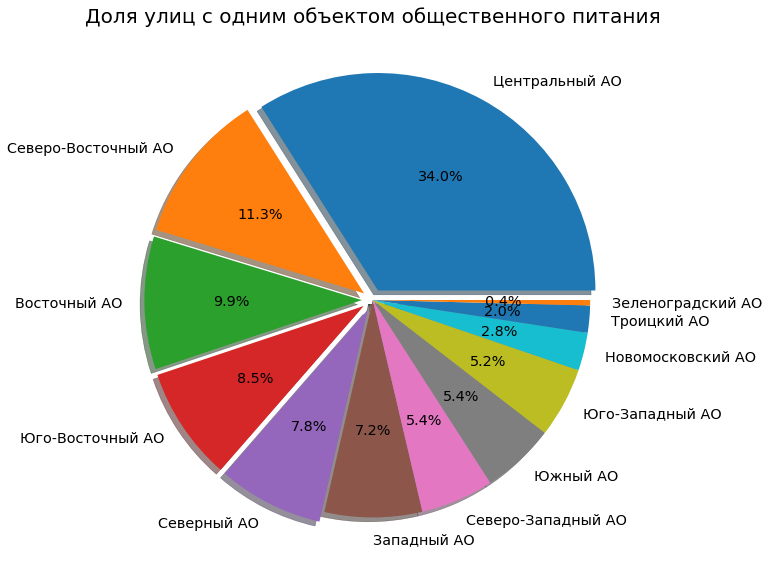

In [115]:
with plt.style.context('seaborn-poster'):    
    explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0]
    streets_one_object['admarea'].value_counts(normalize=True).plot(
    kind='pie', fontsize='x-large', figsize=(10, 10), explode=explode, shadow=True, autopct='%1.1f%%')
    plt.title('Доля улиц с одним объектом общественного питания', loc='center', fontsize=20)
    plt.ylabel('')
    plt.show()

Основная часть приходится на Центральный округ. Центр Москвы, много небольших улочек и переулков, на которых с трудом можно разместить более одного заведения общественного питания и, с трудом, можно разместить в голове арендную плату за них.

### Распределение количества посадочных мест для улиц с большим числом объектов общественного питания.

Группируем таблицу по улицам, числу заведений и среднему количеству посадочных мест в них.

In [116]:
street_seats = rest_data.groupby('street').agg(
    {'id':'count','seats_count':'mean'}).sort_values('id', ascending=False).reset_index()
street_seats.columns = ['street', 'rest_count', 'mean_seats']

In [117]:
street_seats.head()

,street,rest_count,mean_seats
0,проспект Мира,197,62.172589
1,Профсоюзная улица,179,46.966480
2,Ленинградский проспект,169,52.544379
3,Пресненская набережная,165,45.854545
4,Варшавское шоссе,163,52.404908


Посмотрим на распределение заведений на улицу.

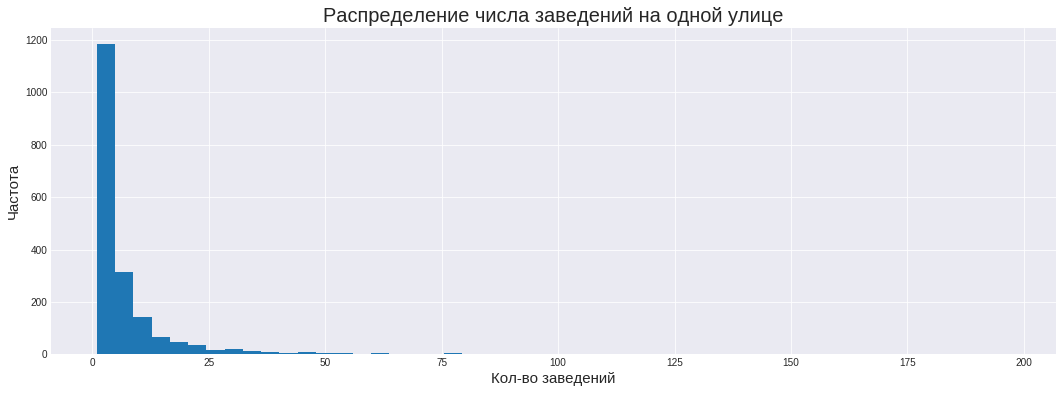

In [118]:
with plt.style.context('seaborn-dark'):   
    street_seats['rest_count'].hist(bins=50, figsize=(18, 6))
    plt.title('Распределение числа заведений на одной улице', loc='center', fontsize=20)
    plt.xlabel('Кол-во заведений', fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

В основном, не более 25 заведений на улицу. Всё, что выше, будем считать улицами с большим числом объектов общественного питания.

Узнаем, сколько это от общего числа улиц.

In [119]:
'{:.1%}'.format((street_seats['rest_count'] > 25).mean())

'6.0%'

Шесть процентов. Сделаем срез по этим улицам.

In [120]:
most_street_seats = street_seats.query('rest_count > 25')

Построим график.

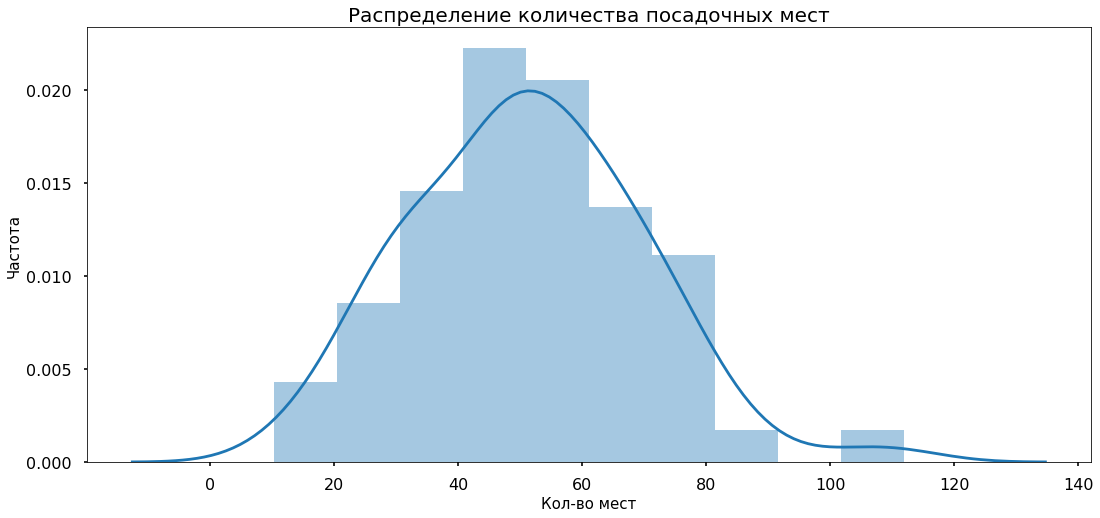

In [121]:
with plt.style.context('seaborn-poster'): 
    plt.figure(figsize=(18, 8))
    sns.distplot(most_street_seats['mean_seats'])
    plt.title('Распределение количества посадочных мест', loc='center', fontsize=20)
    plt.xlabel('Кол-во мест', fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

Для заведений, расположенных на улицах с большим числом объектов общественного питания, характерно, в среднем, от 40 до 60 посадочных мест.

# Вывод

По результатам исследования рынка заведений общественного питания Москвы, имеем следующие данные:
- Кафе - самый распространённый объект общественного питания. Его доля составляет около 40% от общего числа заведений.
- Несетевые заведения занимают 80% рынка, сетевые - порядка 20%.
- Сетевое распространение характерно, большей частью, для предприятий быстрого обслуживания, отделов кулинарии и ресторанов.
- В среднем, на сетевое заведение, приходится 40 посадочных мест. Прямой зависимости увеличения посадочных мест, от количества объектов внутри сети - нет.
- Среди всех объектов общественного питания, наибольшее количество посадочных мест предлагают столовые. Также, в первую пятёрку входят рестораны, буфеты, бары и кафе.
- Улицы, попадающие в первую десятку по количеству объектов общественного питания, имеют в своём распоряжении более сотни заведений. Лидер списка - проспект Мира, с двумя сотнями заведений. Основная часть "десятки" находится в Южном и Юго-Западном административных округах Москвы.
- В Москве около пятисот улиц с одним заведением общественного питания. Основная доля, 34%, приходится на Центральный административный округ.
- Для заведений, расположенных на улицах с большим числом объектов общественного питания, характерно, в среднем, от 40 до 60 посадочных мест.

**Рекомендации**

Исходя из текущего положения дел на рынке, рекомендуется открыть небольшое кафе. 

- Персонал-роботы - весьма оригинальное решение, поэтому целесообразно рассмотреть для открытия Центральный округ, как место наибольшего скопления туристов и гостей города. Кафе может стать одной из достопримечательностей, в том числе и мирового масштаба. 
- Вместимость - порядка 40 посадочных.
- При условии успешности заведения, можно рассмотреть открытие в других, прилегающих районах.
- Развиваться в сеть, более трёх-пяти заведений, не рекомендуется. Есть опасность поглощения более крупными, устоявшимися на рынке сетевыми брендами. Лучше сделать упор на качество и наполнение отдельно взятых кафе.
- Если тренд окажется успешным, возможно, другие игроки на рынке захотят перенять наши решения, а мы сможем извлечь из этого дополнительные прибыли.

Презентация https://disk.yandex.ru/d/VQctVBCWVCU9Ag